The following code helps you visualize the submarine data and contains the crucial information about the data such as size of measurement domain, number of grid points and frequency modes etc. 

Our first task is to import the data into python (similarly MATLAB). Three files are available, "subdata.npy" is a numpy binary file most conveninet for Python users. "subtata.mat" is best if you plan to use MATLAB and "subdata.csv" is the same data in text format if you are having trouble with the other formats. In MATLAB you can simply use the load command. In Python, and in particular if you are using something like Colab you need some utilities to load the data. Here's a small snippet for loading data from your Google drive.   

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import plotly.graph_objects as go


data_path = './subdata.npy'

d = np.load(data_path) # huge matrix of size 262144 x 49 (columns contain flattened 3d matrix of size 64x64x64)
data = d.reshape((64, 64, 64, 49))

# Collaborated with:

Eric Ye and Chenab

## Task 1

In [3]:
L = 10   # Spatial domain goes from -L to L
n = 64   # Grid size
x = np.linspace(-L, L, n + 1)[:-1]  # Spatial grid in each dimension

# Define frequency vector  k  and its shift ks
k = (2 * np.pi / (2 * L)) * np.concatenate(
    (np.arange(0, n // 2), np.arange(-n // 2, 0))
)
ks = np.fft.fftshift(k)

# Accumulate the averaged FFT across the 49 time points
average = np.zeros((n, n, n), dtype=complex)

for j in range(49):
    Sn = data[:, :, :, j]
    Stn = np.fft.fftn(Sn)
    average += Stn

# Shift and take magnitude
average = np.fft.fftshift(average)
average_abs = np.abs(average)

flatAve = average_abs.flatten()
max_index = np.argmax(flatAve)
max_coords = np.unravel_index(max_index, average_abs.shape)

kx, ky, kz = ks[max_coords[0]], ks[max_coords[1]], ks[max_coords[2]]
print("Dominant Frequency: ", (kx, ky, kz))


# fig = go.Figure(data=go.Volume(
#     x=np.repeat(ks, n*n),
#     y=np.tile(np.repeat(ks, n), n),
#     z=np.tile(ks, n*n),
#     value=average_abs.flatten(),
#     isomin=average_abs.min(),
#     isomax=average_abs.max(),
#     opacity=0.1,
#     surface_count=10,
#     colorscale='Hot'
# ))
# fig.update_layout(title="3D Volume of Averaged Fourier Transform")
# fig.show()


Dominant Frequency:  (2.199114857512855, 5.340707511102648, -6.911503837897545)


Dominant Frequency: (2.199114857512855, 5.340707511102648, -6.911503837897545)


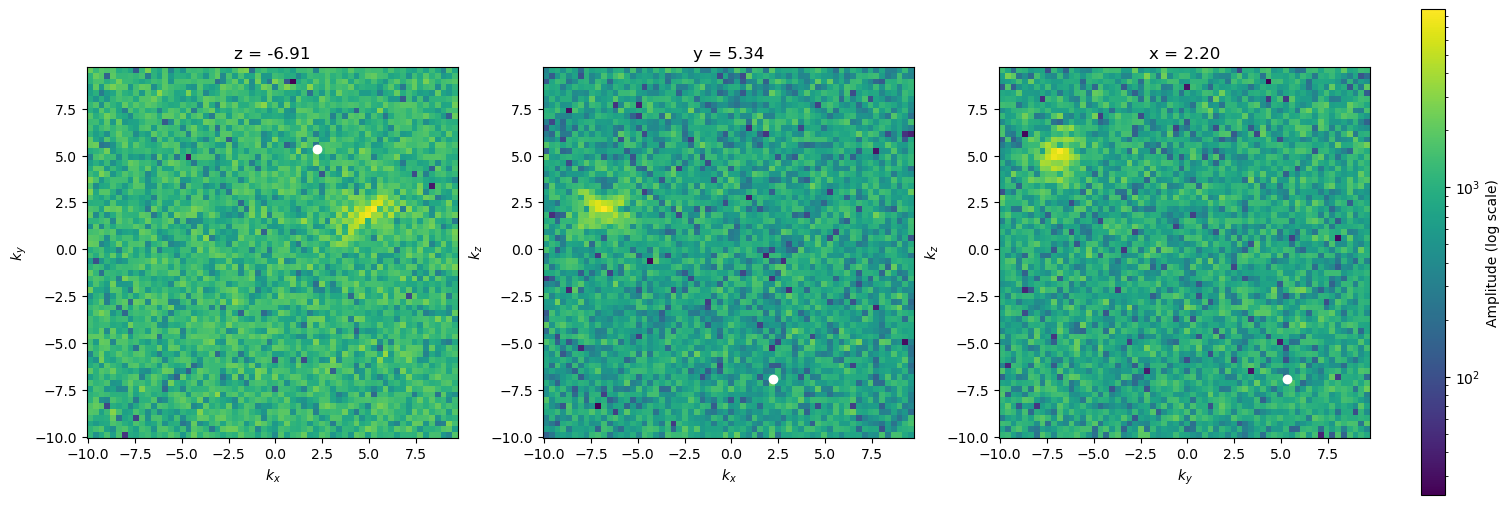

In [4]:
ix, iy, iz = max_coords
print("Dominant Frequency:", (ks[ix], ks[iy], ks[iz]))

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

slices = [
    (average_abs[:, :, iz],  (r'$k_x$', r'$k_y$'), (ks[ix], ks[iy]), f"z = {ks[iz]:.2f}"),
    (average_abs[:, iy, :],  (r'$k_x$', r'$k_z$'), (ks[ix], ks[iz]), f"y = {ks[iy]:.2f}"),
    (average_abs[ix, :, :],  (r'$k_y$', r'$k_z$'), (ks[iy], ks[iz]), f"x = {ks[ix]:.2f}"),
]

for ax, (slice2d, (xlabel, ylabel), (px, py), title) in zip(axes, slices):
    im = ax.imshow(
        slice2d, 
        extent=[ks[0], ks[-1], ks[0], ks[-1]],
        origin='lower',
        # cmap='hot',
        norm=LogNorm()
    )
    ax.plot(px, py, 'wo', markersize=6)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

fig.colorbar(im, ax=axes, fraction=0.02, pad=0.04, label='Amplitude (log scale)')

plt.show()
fig.savefig("Dominant_Frequencies.png", dpi=300, bbox_inches="tight")


## Task 2

In [5]:
tau = 0.01

Kx, Ky, Kz = np.meshgrid(ks, ks, ks, indexing='ij')

filter_3d = np.exp(-tau * ((Kx - kx)**2 + (Ky - ky)**2 + (Kz - kz)**2))

x = np.zeros(49)
y = np.zeros(49)
z = np.zeros(49)

for i in range(49):
    Sn = data[:, :, :, i]
    # So basically we want to do FFT, then shift, then filter, then inverse shift, then inverse FFT
    # FFT -> shift -> filter -> inverse shift -> inverse FFT
    Stn = np.fft.fftn(Sn)
    Stn_shifted = np.fft.fftshift(Stn)
    Stn_filt = Stn_shifted * filter_3d
    Stn_filt_unshifted = np.fft.ifftshift(Stn_filt)
    S_filt = np.fft.ifftn(Stn_filt_unshifted)

    max_id = np.argmax(np.abs(S_filt))
    max_coords_3d = np.unravel_index(max_id, S_filt.shape)
    
    # x[i] = x[max_coords_3d[0]]
    # y[i] = x[max_coords_3d[1]]
    # z[i] = x[max_coords_3d[2]]
    x[i] = max_coords_3d[0]
    y[i] = max_coords_3d[1]
    z[i] = max_coords_3d[2]

#### Visualization

In [6]:
fig = go.Figure(data=[go.Scatter3d(
    x=x, 
    y=y, 
    z=z,
    mode='markers+lines',
    marker=dict(
        size=5, 
        color=np.arange(0, 24.5, 0.5),   # color by time
        colorscale='Viridis',
        colorbar=dict(title='Time (hours)'),
        opacity=0.8
    ),
    line=dict(color='blue', width=2)
)])
fig.update_layout(
    scene=dict(
        xaxis_title='X-Position',
        yaxis_title='Y-Position',
        zaxis_title='Z-Position'
    ),
    title='Denoised Trajectory of the Submarine Over Time'
)
fig.show()


# Task 3

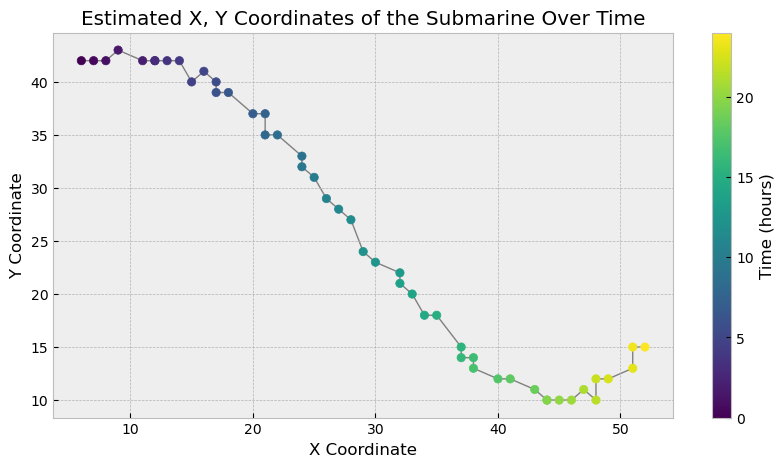

In [ ]:
plt.style.use("bmh")

fig2 = plt.figure(figsize=(10, 5))
ax2 = fig2.add_subplot(111)


time_array = np.arange(0, 24.5, 0.5)  # 49 steps, half-hour increments
sc = ax2.scatter(x, y, c=time_array, cmap="viridis", zorder=2)
ax2.plot(x, y, linestyle='-', color='gray', zorder=1, linewidth=1)

cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Time (hours)')

ax2.set_xlabel('X Coordinate')
ax2.set_ylabel('Y Coordinate')
ax2.set_title('Estimated X, Y Coordinates of the Submarine Over Time')

plt.show()
fig2.savefig('trajectory_xy.png')